# Mask R-CNN Mean Accuracy on Carvana Generated Training Set

In [7]:
import os
import sys
import random
import math
import pandas as pd
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt


In [17]:
###CODE FROM MASK R SAMPLES TO SET UP THE MODEL###

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
#NEEDED IF EVEN NO GPU PRESENT -- BATCH SIZE IS STILL DEFINED FOR CPU EVEN IF NO GPU

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


#Class Names for visualization
class_names = ['car', 'person', 'bicycle', 'BG', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Select Images for Evaluation
We are using the same random seed for getting the random images, so that the list of images will be the same when using differant models. We have to do this becuase the Carvana test set does not include true masks, so we cannot use their pre-split test and train data. So we select 50 images from the training set to be the test set. Because we're using the pre-trained back bone and not doing any transfer learning, we can just evaluate on the test set. 

In [8]:
def get_images_for_testing():
    IMAGE_DIR = os.path.join(ROOT_DIR, "../train/")
    MASKS_DIR = os.path.join(ROOT_DIR, "../train_masks/")

    files = os.listdir(IMAGE_DIR)
    np.random.seed(0)
    img_files = np.random.choice(files, 50, replace = False)
    mask_files = np.array([file_name.replace(".jpg", "_mask.gif") for file_name in img_files])

    return pd.DataFrame({"image": img_files, "true_mask": mask_files})



## Calculate DICE Coefficient

In [9]:
def calculate_accuracy(true_mask, predicted_mask):
    # Predicted mask must be reshaped from (1280,1918,1) to (1280,1918)
    width, height = np.shape(true_mask)
    
    if np.shape(predicted_mask)[2] >= 2:
                predicted_mask = predicted_mask[:,:,0]
         
    #drop all non-car object predictions    
    predicted_mask = np.reshape(predicted_mask, (width,height))
    
    # True mask pixels are either 0 (black) for the car pixels or 255 (white) for other pixels. 
    #Convert to boolean of whether a pixel is part of the car or not.
    true_mask = np.array(true_mask, dtype=int)
    true_mask = np.greater(true_mask, 0)
    
    # Count the number of pixels in each mask and the intersection of pixels between masks
    pred_pixels = np.count_nonzero(predicted_mask)
    true_pixels = np.count_nonzero(true_mask)
    #All vaues 0 or 1, so gets 1 if the true mask and the predicted mask are the same, otherwise 0
    #Then sums the total number of pixels that overlap between the two masks.
    intersect = np.sum(np.multiply(true_mask, predicted_mask))
    
    # Calculate the Dice coefficient
    return (2*intersect)/(pred_pixels + true_pixels)
                          

## GET MEAN ACCURACY FOR CARVANA TRAINING SET

In [14]:
IMAGE_DIR = os.path.join(ROOT_DIR, "../train/")
MASKS_DIR = os.path.join(ROOT_DIR, "../train_masks/")

def segment_all_images_and_get_mean_accuracy():
    image_and_mask_file_paths = get_images_for_testing()
    
    accuracys = []
    
    for index, (image_path, mask_path)  in enumerate(image_and_mask_file_paths.values):
        if index > 48:
            break;
        
        img = skimage.io.imread(IMAGE_DIR + image_path)
        
        #Most likely object is first. Luckily Mask-R correctly predicts that the 
        #Car is most likely every time. 
        result = model.detect([img])
        predicted_mask = result[0]['masks']

        true_mask = skimage.io.imread(MASKS_DIR + mask_path)

        accuracys.append(calculate_accuracy(true_mask, predicted_mask))

    return np.mean(accuracys)

print("Average Mean of 50 Test Carvana Images: " + str(segment_all_images_and_get_mean_accuracy()))

Average Mean of 50 Test Carvana Images: 0.9702537483660393


## Visualization of A Carvana Car For the Paper

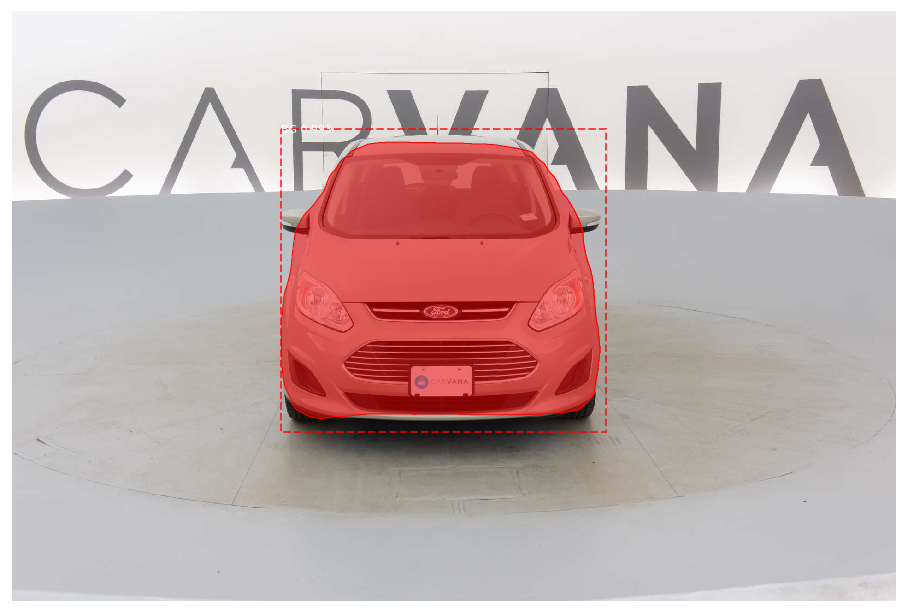

Dice Coeffecient: 0.9640362091100638


In [26]:

img = skimage.io.imread(IMAGE_DIR +'3810c5e1cdeb_01.jpg')
true_mask = skimage.io.imread(MASKS_DIR + '3810c5e1cdeb_01_mask.gif')


result = model.detect([img])[0]
predicted_mask = result['masks']

visualize.display_instances(img, result['rois'], result['masks'], result['class_ids'], 
                            class_names, result['scores'])
print("Dice Coeffecient: " + str(calculate_accuracy(true_mask, predicted_mask)))

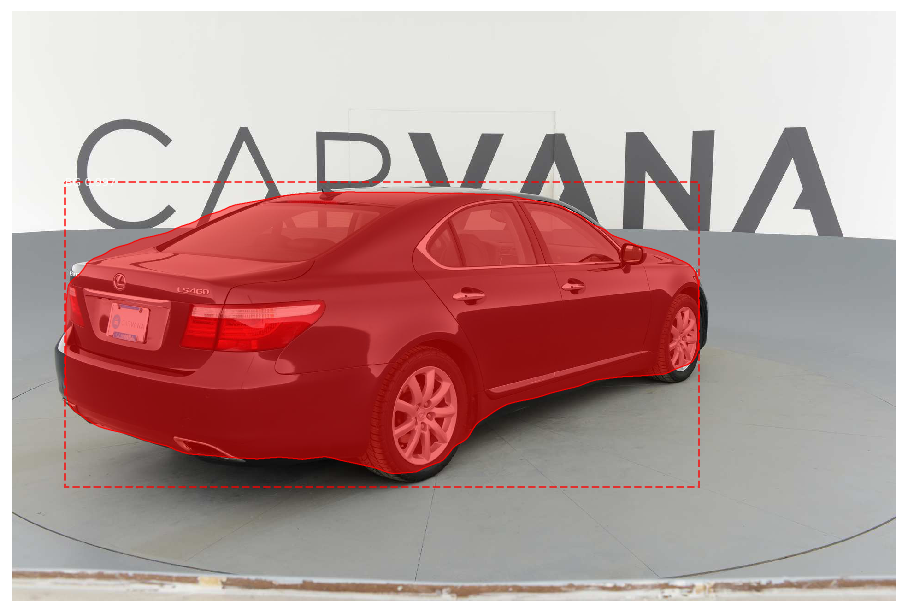

Dice Coeffecient: 0.9734815146005656


In [27]:

img = skimage.io.imread(IMAGE_DIR +'528eb34a4c29_11.jpg')
true_mask = skimage.io.imread(MASKS_DIR + '528eb34a4c29_11_mask.gif')

result = model.detect([img])[0]
predicted_mask = result['masks']

visualize.display_instances(img, result['rois'], result['masks'], result['class_ids'], 
                            class_names, result['scores'])
print("Dice Coeffecient: " + str(calculate_accuracy(true_mask, predicted_mask)))